## Predict Light Sheet Vessels

In this notebook we test prediction on a full 2D slice

In [1]:
import napari
viewer = napari.Viewer()

from skimage.io import imread
from pathlib import Path
import torch
import numpy as np
from tnia.deeplearning.dl_helper import quantile_normalization
from torchvision import transforms
from torchvision.transforms import v2

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup paths

In [2]:
from pathlib import Path
import os
tnia_images_path = Path("D:/images/tnia-python-images")
#tnia_images_path = Path("/home/bnorthan/images/tnia-python-images")
parent_path = tnia_images_path / "imagesc/2025_03_19_vessel_3D_lightsheet"
models_path = parent_path / 'models'

im_name = 'image_175.tif'
im = imread(str(parent_path / (im_name)))

## Load unet

In [3]:
net = torch.load( Path(models_path) / 'model_march25.pth' )
device = torch.device("cuda")
temp = net.to(device)

## Apply unet

In this cell we apply the unet.  

1.  We have to normalize (need to make sure we normalize the same way as the network was trained)
2.  Convert to tensor
3.  Add batch num and channel dimensions with unsqueeze
4.  calculate logits using 
5.  (in a subsequent cell) use softmax and argmax to convert logits to predictions


In [6]:
# Visualize predictions
from tnia.deeplearning.dl_helper import quantile_normalization

#im, raw = train_dataset[10]

net.eval()

print(im.shape, im.min(), im.max())

# normalize the image
im = quantile_normalization(im)
im = im.astype(np.float32)
print(im.shape, im.min(), im.max())

# convert to tensor calling unqueeze twice to add trivial batch and channel dimensions
im_tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0).to(device)       
print('input shape', im_tensor.shape)

use_sliding_window = True

if not use_sliding_window:
    with torch.no_grad():
        logits=net(im_tensor)
else:
    from monai.inferers import sliding_window_inference

    with torch.no_grad():
        #logits = net(im_tensor)  # Forward pass through the model
        # Sliding window inference
        logits = sliding_window_inference(
            im_tensor,                      # Input tensor
            256,              # Patch size
            1,                       # Batch size during inference
            net,              # Model for inference
            #overlap=0.125          # Overlap factor

        )

print('output logits shape',logits.shape)
num_classes = logits.shape[1]
print('num classes', num_classes)

(3080, 2868) 0.0 1.0
(3080, 2868) 0.0 1.0
input shape torch.Size([1, 1, 3080, 2868])
output logits shape torch.Size([1, 3, 3080, 2868])
num classes 3


## Plot logits

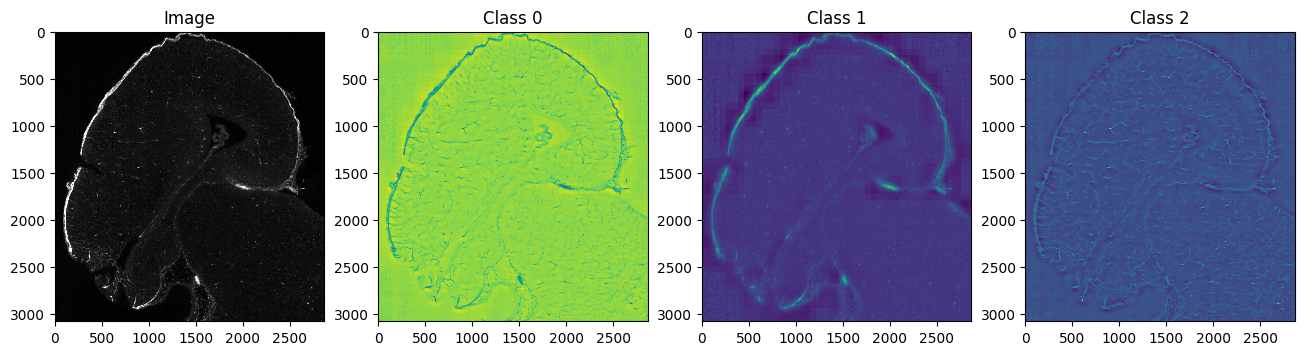

In [9]:
from tnia.plotting.plt_helper import imshow_multi2d

#im = np.transpose(im, (1,2,0))
classes = []
colormaps = []
colormaps.append('gray')

titles = []
titles.append('Image')
for i in range(num_classes):
    classes.append(logits[0,i,:,:].cpu().detach().numpy())
    titles.append('Class ' + str(i))
    colormaps.append('viridis')

images = [im]+classes

fig = imshow_multi2d(images, titles, 1, num_classes+1, 16, 10,colormaps=colormaps)

In [10]:
viewer.add_image(im, name='Image', colormap='gray')

for i in range(num_classes):
    print(classes[i].min(), classes[i].max())
    viewer.add_image(logits[0,i,:,:].cpu().detach().numpy(), name='Class ' + str(i))

-19.736511 7.980876
-5.3294044 15.021495
-7.8070946 19.451916


## Convert logits to predictions

In [11]:
print(logits.shape)
import torch.nn.functional as F

# Apply softmax along the class dimension (dim=1)
probabilities = F.softmax(logits, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1) 

torch.Size([1, 3, 3080, 2868])


In [12]:
viewer.add_labels(predicted_classes.cpu().numpy()+1)

<Labels layer 'Labels' at 0x1e200e59ff0>